In [1]:
import geopandas as gpd
from pyproj import Proj, transform
from shapely.geometry import Point
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from pyproj import Proj, transform
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import dask.dataframe as dd
from rasterio.transform import from_origin
import numpy as np
import rasterio

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [3]:
if lng:
    lon = lng

In [4]:
lonlat=(lon, lat)

In [5]:
buildings = gpd.read_parquet(f"./output/{place}/buildings_morphometric_var.pq")
tessellation = gpd.read_parquet(f"./output/{place}/tessellation_morphometric_var.pq")
edges = gpd.read_parquet(f"output/{place}/edges.pq")
nodes = gpd.read_parquet(f"output/{place}/nodes.pq")
stroke = gpd.read_parquet(f"output/{place}/stroke_gdf.pq")

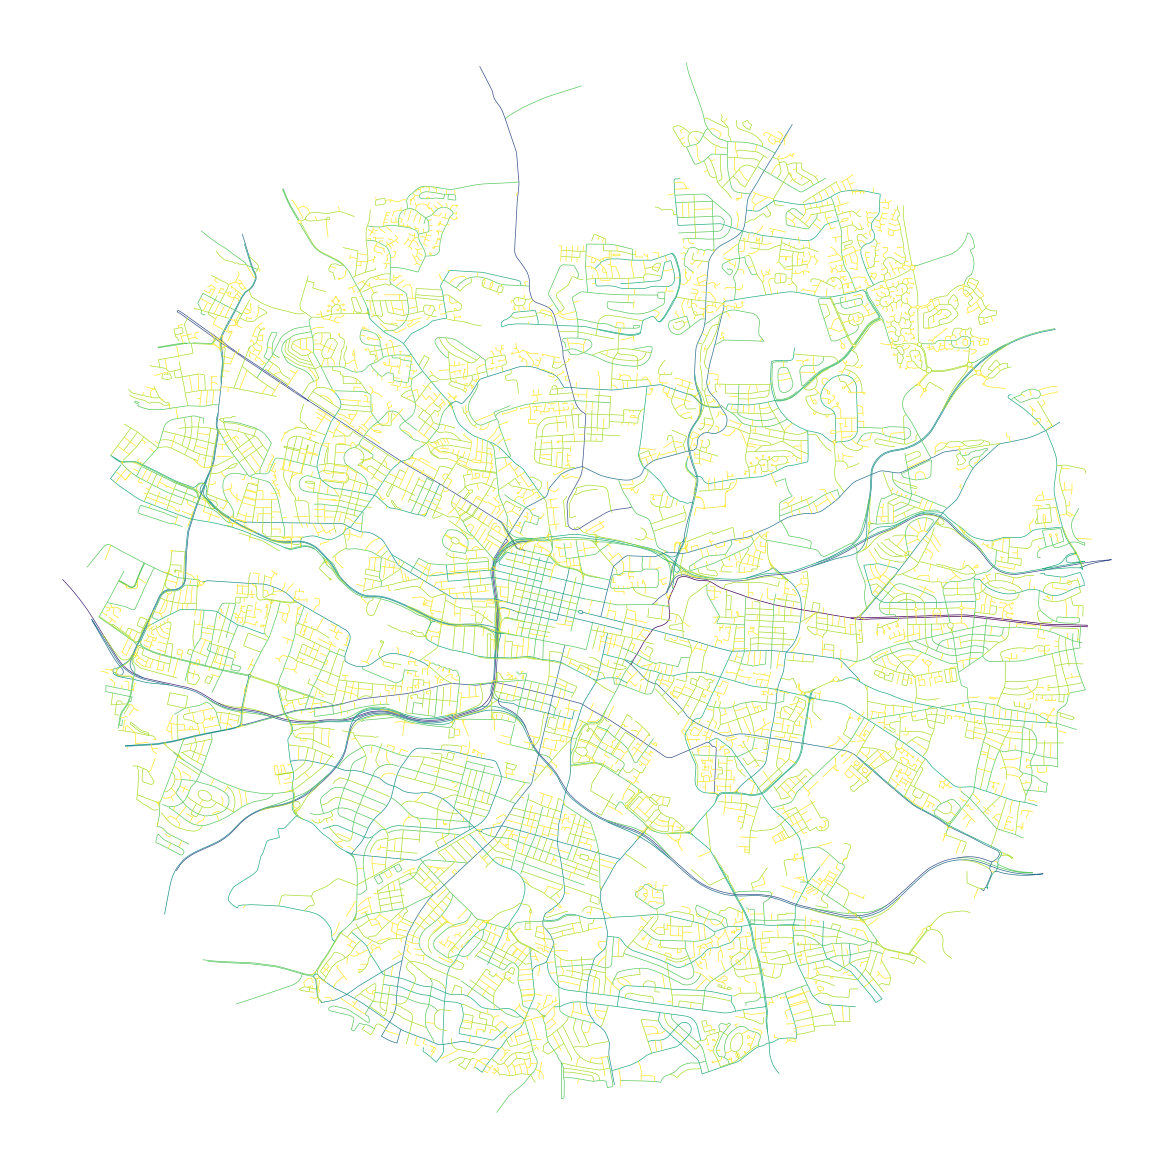

In [6]:
stroke.plot(stroke.length,
                figsize=(15, 15),
                cmap="viridis_r",
                linewidth=.5,
                scheme="headtailbreaks"
               ).set_axis_off()

In [7]:
stroke["stroke_length"] = stroke.length
stroke = stroke.drop(columns=["n_segments"])

In [8]:
buildings_merged = buildings.merge(tessellation.drop(columns=['geometry']), on='uID', how='inner')
buildings_merged_centroids = buildings_merged
buildings_merged_centroids["geometry"] = buildings_merged_centroids['geometry'].centroid

In [9]:
# Your latitude and longitude tuple (latitude, longitude)

# Transform the coordinates
centre_point_4326 = Point(lon, lat)
x_centre, y_centre = transform(4326, local_crs, lat, lon)
centre_point_local_crs = Point(x_centre, y_centre)

/tmp/ipykernel_29876/4192890295.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_centre, y_centre = transform(4326, local_crs, lat, lon)


## Linear Regression

In [10]:
buildings_merged_centroids['distance_to_centre'] = buildings_merged_centroids['geometry'].distance(centre_point_4326)
buildings_merged = buildings_merged_centroids.drop(columns=["uID", "geometry"])
buildings_merged = buildings_merged.dropna()

In [11]:
# Response variable
y = buildings_merged['distance_to_centre']

# Feature variables (excluding the response variable)
X = buildings_merged.drop(columns=['distance_to_centre'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_scaled, y)

# Coefficients and Intercept
coefficients = model.coef_
intercept = model.intercept_

# Predictions
predictions = model.predict(X_scaled)

# Number of observations and number of features
n = len(y)
p = X.shape[1]

# Residual Sum of Squares and Total Sum of Squares
rss = np.sum((y - predictions) ** 2)
tss = np.sum((y - np.mean(y)) ** 2)

# R-squared and Adjusted R-squared
r_squared = 1 - (rss / tss)
adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# Standard Error of the coefficients
mse = rss / (n - p - 1)
se = np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))))

# t-statistics and p-values for coefficients
t_stats = coefficients / se
p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]

# F-statistic
f_statistic = (r_squared / p) / ((1 - r_squared) / (n - p - 1))

def get_significance_asterisks(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': se,
    't value': t_stats,
    'p value': p_values,
    'Significance': [get_significance_asterisks(p) for p in p_values]
}, index=X.columns)
summary_df.loc['Intercept'] = [intercept, np.nan, np.nan, np.nan, '']

# Print summary statistics
print(f"Number of Observations: {n}")
print(f"R-squared: {r_squared}")
print(f"Adjusted R-squared: {adjusted_r_squared}")
print(f"F-statistic: {f_statistic}\n")

Number of Observations: 40860
R-squared: 0.20582490975495915
Adjusted R-squared: 0.20533868804618405
F-statistic: 423.31493234524726



In [12]:
summary_df

Coefficient  \
buildings_neighbours_200                              1387.415357   
building_area                                           79.479849   
building_circular_compactness                         -300.856795   
building_elongation                                    -64.315026   
building_squareness                                    -12.679361   
building_eri                                           -93.054213   
building_orientation                                    70.144300   
building_neighbour_dist                                 17.455100   
building_neighbourhood_interbuilding_distance           26.545847   
building_circular_compactness_weight                  -403.953835   
building_elongation_weight                             513.659496   
building_squareness_weight                            -104.291143   
building_eri_weight                                    351.147556   
building_neighbour_dist_weight                        -391.080671   
building_neighbourhood_interbuilding_distance_w...     643.289760   
building_orientation_weight                           -290.723008   
tess_area                                               -9.353654   
tessellation_neighbours                                113.950625   
tess_convexity                                         -59.639250   
tess_covered_area                                       37.841186   
tess_orientation                                       -50.143223   
tess_convexity_weight                                   32.818080   
tess_covered_area_weight                               130.010778   
tess_orientation_weight                                -11.412000   
tess_rea_theil                                         464.594903   
Intercept                                           714557.143024   

                                                    Standard Error    t value  \
buildings_neighbours_200                                 24.368329  56.935185   
building_area                                            17.159022   4.631957   
building_circular_compactness                            41.353641  -7.275219   
building_elongation                                      35.016165  -1.836724   
building_squareness                                      16.785613  -0.755371   
building_eri                                             27.771417  -3.350719   
building_orientation                                     21.314752   3.290880   
building_neighbour_dist                                  24.642888   0.708322   
building_neighbourhood_interbuilding_distance            35.815354   0.741186   
building_circular_compactness_weight                     57.493602  -7.026066   
building_elongation_weight                               43.237372  11.879989   
building_squareness_weight                               22.141705  -4.710168   
building_eri_weight                                      39.498624   8.890121   
building_neighbour_dist_weight                           36.205031 -10.801832   
building_neighbourhood_interbuilding_distance_w...       42.643169  15.085412   
building_orientation_weight                              28.351722 -10.254157   
tess_area                                                25.990985  -0.359881   
tessellation_neighbours                                  19.283470   5.909239   
tess_convexity                                           16.310355  -3.656527   
tess_covered_area                                        30.852428   1.226522   
tess_orientation                                         19.204058  -2.611074   
tess_convexity_weight                                    17.830794   1.840528   
tess_covered_area_weight                                 28.247245   4.602600   
tess_orientation_weight                                  25.977147  -0.439309   
tess_rea_theil                                           21.289203  21.823029   
Intercept                                                      NaN        NaN   

  

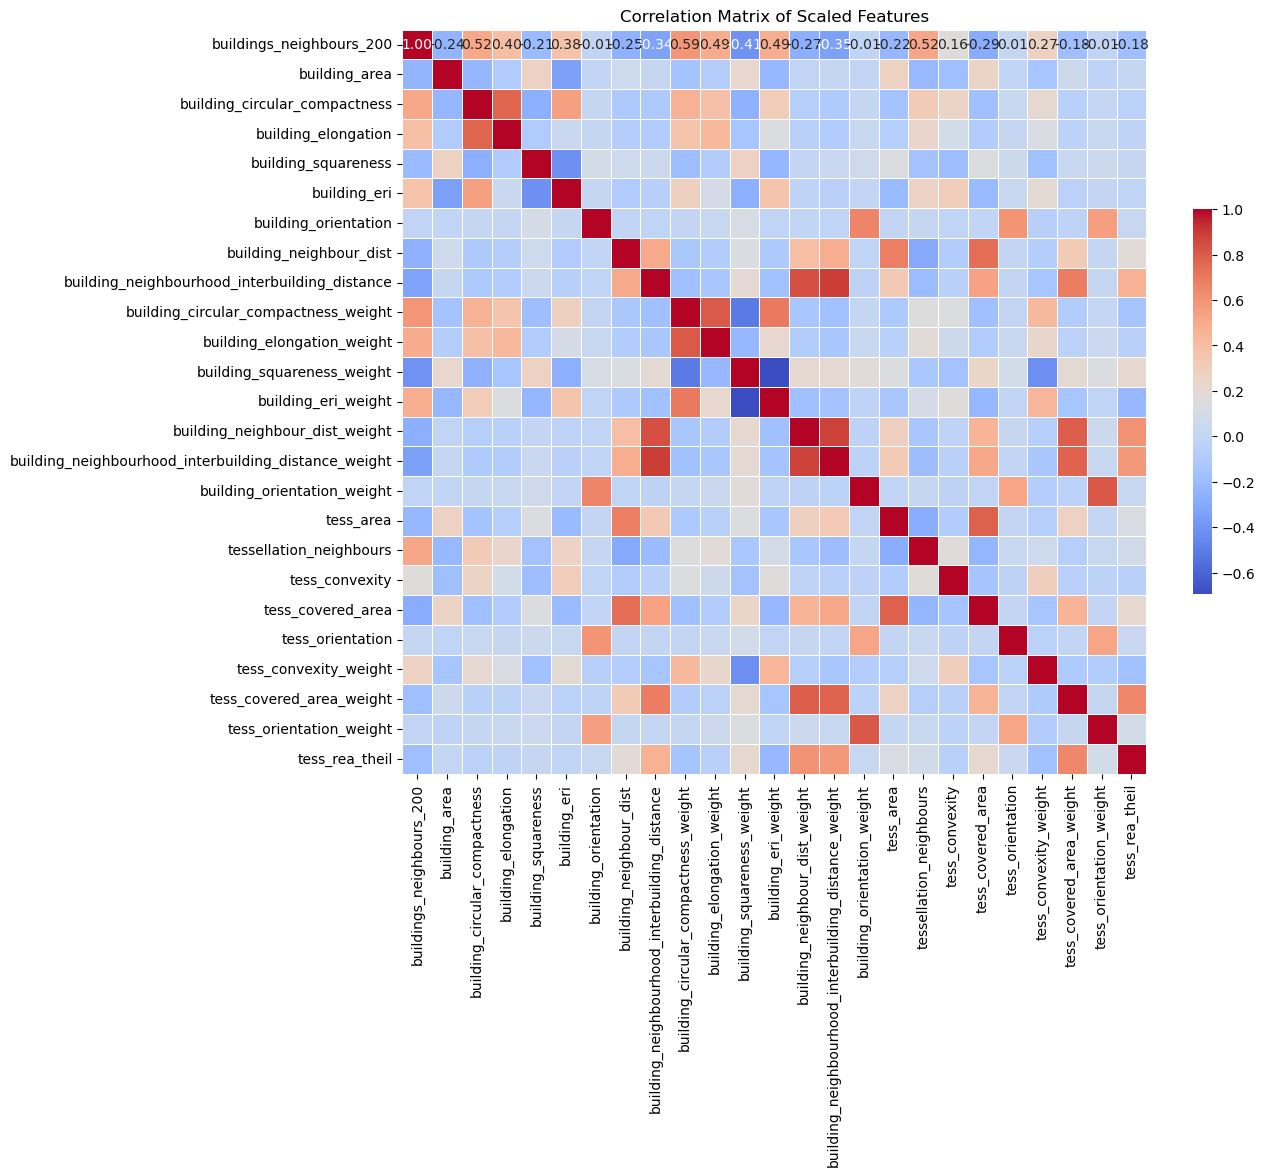

In [13]:
# Convert the numpy array back to a pandas DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calculate the correlation matrix
corr_matrix = X_scaled_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adding title
plt.title('Correlation Matrix of Scaled Features')

# Show the plot
plt.show()

In [14]:
residuals = y - predictions

In [15]:
# # Creating a residual plot with Seaborn
# plt.figure(figsize=(10, 6))
# sns.residplot(x=predictions, y=residuals, lowess=True, scatter_kws={'alpha': 0.05, 's': 10}, line_kws={'color': 'red'})
# plt.xlabel('Predicted Values')
# plt.ylabel('Residuals')
# plt.title('Seaborn Residual Plot')
# plt.show()

In [16]:
# plt.figure(figsize=(8, 6))
# stats.probplot(residuals, dist="norm", plot=plt)
# plt.title('Q-Q Plot of Residuals')
# plt.xlabel('Theoretical Quantiles')
# plt.ylabel('Ordered Values')
# plt.show()

In [17]:
raster_data = gpd.read_parquet(f"output/{place}/raster_data.pq").to_crs(local_crs)

In [18]:
raster_data

land  ghs-smod  ghs-built-v  ghs-built-c  ghs-pop  ghs-built-s  row  \
32   10000        30        43244           13      133         3687    1   
33   10000        30        41874            9       99         3687    1   
34    9995        30        38830            7       99         3354    1   
35    9964        30        30717            6       83         3249    1   
36    9964        30        26824            8       74         3249    1   
..     ...       ...          ...          ...      ...          ...  ...   
553   9991        30        23438            9       45         3404   17   
554   9961        30        26233           10       45         3263   17   
555   9961        30        23970           20       23         3263   17   
556   9892        30        23970            5       23         3713   17   
557   9926        30        21907            4       40         3431   17   

     col                                           geometry  
32     1  POLYGON ((258217.703 666785.345, 258285.067 66...  
33     2  POLYGON ((258285.067 666783.137, 258352.432 66...  
34     3  POLYGON ((258352.432 666780.929, 258419.797 66...  
35     4  POLYGON ((258419.797 666778.723, 258487.161 66...  
36     5  POLYGON ((258487.161 666776.518, 258554.526 66...  
..   ...                                                ...  
553   26  POLYGON ((259839.723 664813.315, 259907.118 66...  
554   27  POLYGON ((259907.118 664811.133, 259974.513 66...  
555   28  POLYGON ((259974.513 664808.951, 260041.908 66...  
556   29  POLYGON ((260041.908 664806.770, 260109.303 66...  
557   30  POLYGON ((260109.303 664804.591, 260176.698 66...  

[501 rows x 9 columns]

In [19]:
# Create a 50 km buffer around the point
buffer_circle = gpd.GeoDataFrame({'geometry': [Point(lon, lat)]}, crs=4326).to_crs(local_crs).buffer(radius * 1000)

In [20]:
# Get bounds
minx, miny, maxx, maxy = raster_data.total_bounds
min_dist = min([abs(minx-lonlat[1]), abs(miny-lonlat[0]), abs(maxx-lonlat[1]), abs(maxy-lonlat[0])])

# Create a GeoDataFrame with the specified point
gdf = gpd.GeoDataFrame(geometry=[Point(lonlat[0], lonlat[1])], crs=crs)

# The UTM zone number can be calculated from the longitude
utm_zone = int((lonlat[0] + 180) / 6) + 1
# Determine the hemisphere and assign the appropriate UTM CRS
if lonlat[1] >= 0:  # Northern Hemisphere
    local_utm_crs = f'EPSG:326{utm_zone:02d}'
else:  # Southern Hemisphere
    local_utm_crs = f'EPSG:327{utm_zone:02d}'

# Reproject to a local UTM CRS
gdf_utm = gdf.to_crs(local_utm_crs)

# Create a 50 km buffer around the point
buffer_circle = gdf_utm.buffer((radius) * 1000).to_crs(local_crs)  # Convert km to meters

In [21]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the first GeoDataFrame
# cells_in_circle.plot(ax=ax, color='blue', edgecolor='k', alpha=0.2)  # Adjust color and edgecolor as needed

# # Plot the second GeoDataFrame on the same axes
# buffer_circle.plot(ax=ax, color='red', alpha=0.2)  # Adjust color and alpha for transparency as needed

# tessellation.plot(ax=ax, color="green", alpha=0.4)

# # Optionally set axis limits or other plot properties
# # ax.set_xlim([xmin, xmax])
# # ax.set_ylim([ymin, ymax])

# ctx.add_basemap(ax, crs=local_crs,source=ctx.providers.CartoDB.Positron)

# plt.show()

In [22]:
cells_in_circle = raster_data[raster_data["geometry"].within(buffer_circle.geometry[0])]


<Axes: >

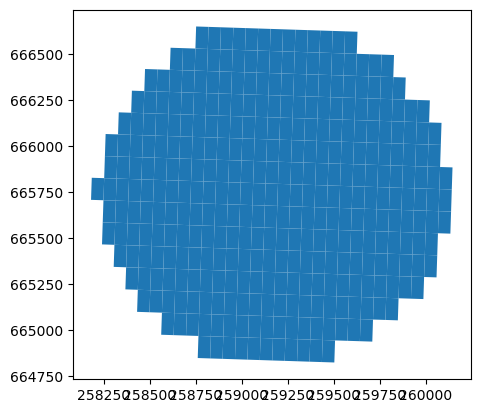

In [23]:
cells_in_circle.plot()

In [24]:
cells_in_circle 

land  ghs-smod  ghs-built-v  ghs-built-c  ghs-pop  ghs-built-s  row  \
71    9996        30        20833            4       31         4006    2   
72    9999        30        17688           22       23         3318    2   
73    9995        30        17688           11       23         3173    2   
74    9989        30        14777            0        6         3025    2   
75    9905        30        16685            0        4         2088    2   
..     ...       ...          ...          ...      ...          ...  ...   
512   9990        30        42383           23       38         6581   16   
513   9990        30        42383           21       45         6048   16   
514   9988        30        38059           13       31         4998   16   
515   9996        30        34486           21       31         4649   16   
516  10000        30        31326           12       48         4467   16   

     col                                           geometry  
71     9  POLYGON ((258752.707 666647.887, 258820.074 66...  
72    10  POLYGON ((258820.074 666645.686, 258887.440 66...  
73    11  POLYGON ((258887.440 666643.487, 258954.807 66...  
74    12  POLYGON ((258954.807 666641.289, 259022.174 66...  
75    13  POLYGON ((259022.174 666639.092, 259089.541 66...  
..   ...                                                ...  
512   16  POLYGON ((259169.674 664955.020, 259237.067 66...  
513   17  POLYGON ((259237.067 664952.827, 259304.459 66...  
514   18  POLYGON ((259304.459 664950.635, 259371.852 66...  
515   19  POLYGON ((259371.852 664948.444, 259439.245 66...  
516   20  POLYGON ((259439.245 664946.254, 259506.638 66...  

[340 rows x 9 columns]

In [25]:
# # Assuming cells_in_circle is a GeoDataFrame
# fig, ax = plt.subplots()
# cells_in_circle.plot(column='row', ax=ax, cmap='Blues')
# plt.show()

In [26]:
buildings_joint = buildings.sjoin(cells_in_circle, how='inner')

In [27]:
joint_gdf = tessellation.join(buildings_joint, on="uID", how="inner", lsuffix="_tess", rsuffix="_build").drop(["uID_tess"], axis=1)

In [28]:
tessellation_not_in_buildings = tessellation[~tessellation['uID'].isin(buildings_joint['uID'])]

<Axes: >

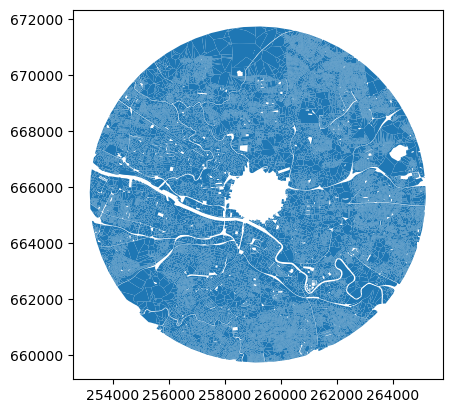

In [29]:
tessellation_not_in_buildings.plot()

In [30]:
joint_gdf.drop(["geometry_tess", "geometry_build", "uID"], axis=1).to_parquet(f"output/{place}/p4-buildings-output.pq")

In [31]:
joint_gdf

uID                                      geometry_tess    tess_area  \
51        51  POLYGON ((259897.638 666124.781, 259897.138 66...  4267.678152   
76        76  POLYGON ((259827.291 665376.778, 259826.852 66...  1412.559277   
76        76  POLYGON ((259827.291 665376.778, 259826.852 66...  1412.559277   
88        88  POLYGON ((259851.838 665203.400, 259852.094 66...  6158.476863   
88        88  POLYGON ((259851.838 665203.400, 259852.094 66...  6158.476863   
...      ...                                                ...          ...   
25571  25571  POLYGON ((258480.370 665118.350, 258479.896 66...  3728.140464   
25601  25601  POLYGON ((259283.182 666348.714, 259286.617 66...  6421.419306   
25601  25601  POLYGON ((259283.182 666348.714, 259286.617 66...  6421.419306   
25601  25601  POLYGON ((259283.182 666348.714, 259286.617 66...  6421.419306   
25681  25681  POLYGON ((259436.201 665093.521, 259436.091 66...  3402.873941   

       tessellation_neighbours  tess_convexity  tess_covered_area  \
51                    0.078549        0.890109       36559.990850   
76                    0.253568        0.879135       35164.205771   
76                    0.253568        0.879135       35164.205771   
88                    0.118665        0.947574       34694.560749   
88                    0.118665        0.947574       34694.560749   
...                        ...             ...                ...   
25571                 0.247581        0.997236       66634.279655   
25601                 0.089083        0.933238       25961.861652   
25601                 0.089083        0.933238       25961.861652   
25601                 0.089083        0.933238       25961.861652   
25681                 0.138518        0.981192       32746.371865   

       tess_orientation  tess_convexity_weight  tess_covered_area_weight  \
51             7.755103               0.940096              47446.617979   
76             0.875671               0.915117              85787.947271   
76             0.875671               0.915117              85787.947271   
88            19.556933               0.934406              60170.211010   
88            19.556933               0.934406              60170.211010   
...                 ...                    ...                       ...   
25571         10.786593               0.921758             156295.914768   
25601         38.403327               0.898752              46860.801808   
25601         38.403327               0.898752              46860.801808   
25601         38.403327               0.898752              46860.801808   
25681         13.906714               0.934627             138382.288672   

       tess_orientation_weight  ...  building_orientation_weight  index_right  \
51                    9.062942  ...                     4.421646          181   
76                   11.893001  ...                    11.268751          398   
76                   11.893001  ...                    11.268751          397   
88                   20.427701  ...                    17.042692          459   
88                   20.427701  ...                    17.042692          429   
...                        ...  ...                          ...          ...   
25571                10.122392  ...                    12.695585          439   
25601                24.197154  ...                    23.284122          171   
25601                24.197154  ...                    23.284122          141   
25601                24.197154  ...                    23.284122          140   
25681                15.473004  ...                    13.790117          453   

        land  ghs-smod  ghs-built-v  ghs-built-c  ghs-pop  ghs-built-s  row  \
51      9712        30        14918            9       43         2088    5   
76      9989        30        30790            5      127         4018   12   
76      9989        30        39612           14       94         4018   12   
88      9989     

In [32]:
collist = list(set(raster_data.columns.tolist()) - {"col", "row", "geometry"})

In [33]:
# Assuming 'gdf' is your GeoDataFrame
# Convert GeoDataFrame to Dask DataFrame
dask_df = dd.from_pandas(joint_gdf.drop(["geometry_tess", "geometry_build", "uID", "uID_build", "index_right"]+ collist, axis=1), npartitions=10)  # You can adjust the number of partitions

# Group by 'row' and 'col'
grouped = dask_df.groupby(["row", "col"])

stats_df = grouped.aggregate(['median', "std"], shuffle='tasks').compute()

In [34]:
out = {}

for column in joint_gdf.drop(["geometry_tess", "geometry_build", "uID", "uID_build", "index_right", "row", "col"] + collist, axis=1).columns:
    print(column)
    q25 = grouped[column].apply(lambda x: x.quantile(0.25), meta=('x', 'f8')).compute()
    q25.name = f"q25"
    q75 = grouped[column].apply(lambda x: x.quantile(0.75), meta=('x', 'f8')).compute()
    q75.name = f"q75"
    # kurtosis = grouped[column].apply(lambda x: x.kurtosis(), meta=('x', 'f8')).compute()
    # kurtosis.name = f"kurtosis"
    # skew =  grouped[column].apply(lambda x: x.skew(), meta=('x', 'f8')).compute()
    # skew.name = f"skew"
    
    out[column] = [stats_df[column], q25, q75]


tess_area


tessellation_neighbours
tess_convexity
tess_covered_area
tess_orientation
tess_convexity_weight
tess_covered_area_weight
tess_orientation_weight
tess_rea_theil
buildings_neighbours_200
building_area
building_circular_compactness
building_elongation
building_squareness
building_eri
building_orientation
building_neighbour_dist
building_neighbourhood_interbuilding_distance
building_circular_compactness_weight
building_elongation_weight
building_squareness_weight
building_eri_weight
building_neighbour_dist_weight
building_neighbourhood_interbuilding_distance_weight
building_orientation_weight


In [35]:
concat_df = pd.DataFrame()

In [36]:
for key in out:
    # Concatenate the Series
    concatenated = pd.concat(out[key], axis=1)

    # Create a MultiIndex using the key and the column names of the concatenated DataFrame
    multi_index = pd.MultiIndex.from_tuples([(key, col) for col in concatenated.columns])

    # Set the MultiIndex to the concatenated DataFrame
    concatenated.columns = multi_index

    # Combine the concatenated DataFrame into stats_df
    concat_df = pd.concat([concat_df, concatenated], axis=1)

In [37]:
# Assume df is your DataFrame

# Transpose the DataFrame
df_transposed = concat_df.T

# Find duplicated rows (originally columns)
duplicates = df_transposed.duplicated()

# List out the names of duplicate columns
duplicate_columns = df_transposed.index[duplicates].tolist()

# Print or process the duplicate column names
print("Duplicate columns:", duplicate_columns)

Duplicate columns: []


In [38]:
# Calculate the count of entries in each cell
cell_counts = dask_df.groupby(['row', 'col']).size().compute()
cell_counts_df = cell_counts.reset_index(name='entry_count')

In [39]:
raster_data.set_index(['row', 'col'], inplace=True)

In [40]:
out_df = gpd.GeoDataFrame(pd.concat([concat_df, raster_data], axis=1).reset_index(), geometry="geometry")
out_df = out_df.merge(cell_counts_df, on=['row', 'col'], how='left')

In [41]:
def calculate_statistics(nodes, out_df):
    # Spatial join - associating each node with a polygon
    joined = gpd.sjoin(nodes, out_df, how='inner', op='intersects')

    # Creating a list to hold results
    results = []

    # Iterating through each unique polygon in the spatial join
    for polygon_id in joined['index_right'].unique():
        # Filter to include only nodes within the current polygon
        nodes_in_polygon = joined[joined['index_right'] == polygon_id]

        # Calculating statistics for each column
        stats = {'polygon_id': polygon_id}
        
        stats[f'nodes_count'] = nodes_in_polygon.iloc[0].count()
        
        for column in nodes.columns:
            if nodes[column].dtype in ['int64', 'float64']:  # Check if column is numeric
                stats[f'{column}_max'] = nodes_in_polygon[column].max()
                stats[f'{column}_min'] = nodes_in_polygon[column].min()
                stats[f'{column}_median'] = nodes_in_polygon[column].median()
                for quantile, value in nodes_in_polygon[column].quantile([0.25, 0.5, 0.75]).items():
                    stats[f'{column}_quantile_{quantile}'] = value

        # Adding stats for this polygon to the results list
        results.append(stats)

    # Creating a DataFrame from the results
    stats_df = pd.DataFrame(results)

    # Ensuring that the merge key in out_df is a regular column (not an index)
    
    out_df.explore()
    
    out_df['polygon_id'] = out_df.index

    # Merging the stats DataFrame with the out_df GeoDataFrame
    merged_df = out_df.merge(stats_df, on='polygon_id', how='left')
    
    merged_df = merged_df.drop(columns=["polygon_id"], axis = 1)

    return merged_df

In [42]:
out_df = calculate_statistics(nodes, out_df)

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
def calculate_line_statistics(edges, out_df, name):
    # Spatial join - associating each line with polygons it intersects
    joined = gpd.sjoin(edges, out_df, how='inner', op='intersects')

    # Creating a list to hold results
    results = []

    # Iterating through each unique polygon in the spatial join
    for polygon_id in joined['index_right'].unique():
        # Filter to include only lines intersecting the current polygon
        lines_in_polygon = joined[joined['index_right'] == polygon_id]
        
        # Calculating statistics for each column
        stats = {'polygon_id': polygon_id}
        
        stats[f'{name}_count'] = lines_in_polygon.iloc[0].count()

        for column in edges.columns:
            if edges[column].dtype in ['int64', 'float64']:  # Check if column is numeric
                stats[f'{column}_max'] = lines_in_polygon[column].max()
                stats[f'{column}_min'] = lines_in_polygon[column].min()
                stats[f'{column}_median'] = lines_in_polygon[column].median()
                for quantile, value in lines_in_polygon[column].quantile([0.25, 0.5, 0.75]).items():
                    stats[f'{column}_quantile_{quantile}'] = value

        # Adding stats for this polygon to the results list
        results.append(stats)

    # Creating a DataFrame from the results
    stats_df = pd.DataFrame(results)

    # Ensuring that the merge key in out_df is a regular column (not an index)
    out_df['polygon_id'] = out_df.index

    # Merging the stats DataFrame with the out_df GeoDataFrame
    merged_df = out_df.merge(stats_df, on='polygon_id', how="left")

    return merged_df

In [44]:
edges = edges.drop(["mm_len", "node_start", "node_end"], axis=1)

In [45]:
out_df = calculate_line_statistics(edges, out_df, "edges")

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [46]:
out_df = calculate_line_statistics(stroke, out_df, "strokes")

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3550: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [47]:
out_df

row  col  (tess_area, median)  (tess_area, std)  (tess_area, q25)  \
0      5   26          5350.962089       1531.994835       4809.320120   
1     12   26          3706.157215       3243.637311       2559.358246   
2     12   25         10463.860664       5348.762446       6845.181660   
3     14   25          5231.054020       4080.948891       3539.157414   
4     13   26          6158.476863       2765.776484       2148.275946   
..   ...  ...                  ...               ...               ...   
496   17   26                  NaN               NaN               NaN   
497   17   27                  NaN               NaN               NaN   
498   17   28                  NaN               NaN               NaN   
499   17   29                  NaN               NaN               NaN   
500   17   30                  NaN               NaN               NaN   

     (tess_area, q75)  (tessellation_neighbours, median)  \
0         5892.604057                           0.069439   
1         4852.956185                           0.192339   
2        12499.375831                           0.140070   
3         5918.276013                           0.118665   
4         6728.592707                           0.118665   
..                ...                                ...   
496               NaN                                NaN   
497               NaN                                NaN   
498               NaN                                NaN   
499               NaN                                NaN   
500               NaN                                NaN   

     (tessellation_neighbours, std)  (tessellation_neighbours, q25)  \
0                          0.012884                        0.064884   
1                          0.086591                        0.161725   
2                          0.059728                        0.132654   
3                          0.053334                        0.100468   
4                          0.022492                        0.107327   
..                              ...                             ...   
496                             NaN                             NaN   
497                             NaN                             NaN   
498                             NaN                             NaN   
499                             NaN                             NaN   
500                             NaN                             NaN   

     (tessellation_neighbours, q75)  ...  \
0                          0.073994  ...   
1                          0.222954  ...   
2                          0.172202  ...   
3                          0.142659  ...   
4                          0.134761  ...   
..                              ...  ...   
496                             NaN  ...   
497                             NaN  ...   
498                             NaN  ...   
499                             NaN  ...   
500                             NaN  ...   

     global_angular_betweeness_quantile_0.25  \
0                                   0.000072   
1                                   0.002268   
2                                   0.000000   
3                                   0.000114   
4                                   0.000735   
..                                       ...   
496                                 0.000000   
497                                 0.000165   
498                                 0.000174   
499                                 0.000053   
500                                 0.000069   

     global_angular_betweeness_quantile_0.5  \
0                                  0.000179   
1                                  0.002328   
2                                  0.000258   
3                                  0.000782   
4                                  0.002213   
..                                      ...   
496                                0.000070   
497                                0.000429   
498          

In [48]:
out_df.geometry

0      POLYGON ((259886.298 666251.165, 259953.670 66...
1      POLYGON ((259859.128 665412.420, 259926.513 66...
2      POLYGON ((259791.742 665414.604, 259859.128 66...
3      POLYGON ((259783.976 665174.962, 259851.365 66...
4      POLYGON ((259855.246 665292.599, 259922.634 66...
                             ...                        
496    POLYGON ((259839.723 664813.315, 259907.118 66...
497    POLYGON ((259907.118 664811.133, 259974.513 66...
498    POLYGON ((259974.513 664808.951, 260041.908 66...
499    POLYGON ((260041.908 664806.770, 260109.303 66...
500    POLYGON ((260109.303 664804.591, 260176.698 66...
Name: geometry, Length: 501, dtype: geometry

In [49]:
out_df.columns = ['_'.join(map(str, col)) if type(col) is tuple else col for col in out_df.columns]

In [50]:
df = out_df.loc[:,~out_df.columns.duplicated()].copy()

In [51]:
df.rename(columns={'raster_val': 'building_height'}, inplace=True)

In [52]:
df.explore()

In [53]:
df.columns.tolist()

['row',
 'col',
 'tess_area_median',
 'tess_area_std',
 'tess_area_q25',
 'tess_area_q75',
 'tessellation_neighbours_median',
 'tessellation_neighbours_std',
 'tessellation_neighbours_q25',
 'tessellation_neighbours_q75',
 'tess_convexity_median',
 'tess_convexity_std',
 'tess_convexity_q25',
 'tess_convexity_q75',
 'tess_covered_area_median',
 'tess_covered_area_std',
 'tess_covered_area_q25',
 'tess_covered_area_q75',
 'tess_orientation_median',
 'tess_orientation_std',
 'tess_orientation_q25',
 'tess_orientation_q75',
 'tess_convexity_weight_median',
 'tess_convexity_weight_std',
 'tess_convexity_weight_q25',
 'tess_convexity_weight_q75',
 'tess_covered_area_weight_median',
 'tess_covered_area_weight_std',
 'tess_covered_area_weight_q25',
 'tess_covered_area_weight_q75',
 'tess_orientation_weight_median',
 'tess_orientation_weight_std',
 'tess_orientation_weight_q25',
 'tess_orientation_weight_q75',
 'tess_rea_theil_median',
 'tess_rea_theil_std',
 'tess_rea_theil_q25',
 'tess_rea_t

<Axes: >

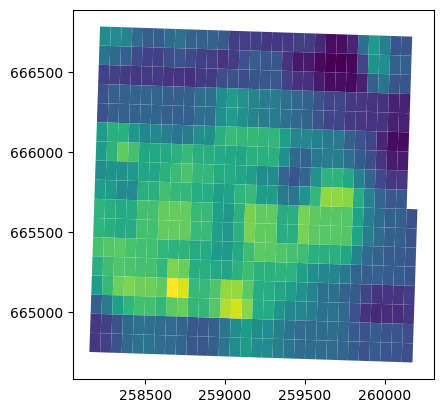

In [54]:
df.plot(column='ghs-built-v')

In [55]:
df.to_parquet(f"output/{place}/p5-grid-output.pq")

In [57]:
# with rasterio.open(f'output/{place}/p5.tif') as src:
#     # Get the transform object
#     transform = src.transform

#     # Extract west, north, and resolution (xres, yres)
#     west = transform.c
#     north = transform.f
#     xres = transform.a
#     yres = -transform.e  # yres is negative as raster origin is top-left


RasterioIOError: output/test/p5.tif: No such file or directory

In [ ]:

# # Open the source raster to get the transform
# with rasterio.open(f'output/{place}.tif') as src:
#     transform = src.transform

#     west = transform.c
#     north = transform.f
#     xres = transform.a
#     yres = -transform.e  # yres is negative as raster origin is top-left

# # Calculate raster dimensions
# n_rows = gdf['row'].max() - gdf['row'].min() + 1
# n_cols = gdf['col'].max() - gdf['col'].min() + 1

# # List of columns to be used as bands
# band_columns = [col for col in gdf.columns if col not in ['row', 'col', 'geometry']]

# # Initialize raster dataset
# with rasterio.open(f"output/{place}/grid_with_summary_stats.tif", 'w', 
#     driver='GTiff', 
#     height=n_rows, 
#     width=n_cols, 
#     count=len(band_columns), 
#     dtype=str(gdf[band_columns[0]].dtype), 
#     crs=gdf.crs, 
#     transform=transform
# ) as dst:
#     for i, column in enumerate(band_columns, start=1):
#         # Create an empty array filled with NaNs (or use a different no-data value)
#         if column == 'building_height':
#             # For 'building_height', initialize with zeros
#             band_data = np.zeros((n_rows, n_cols))
#         else:
#             # For other columns, initialize with NaNs
#             band_data = np.full((n_rows, n_cols), np.nan)

#         # Update the array with data from the GeoDataFrame
#         for _, row in gdf.iterrows():
#             row_idx, col_idx = row['row'] - gdf['row'].min(), row['col'] - gdf['col'].min()
#             band_data[row_idx, col_idx] = row[column]

#         dst.write(band_data, i)

In [ ]:
# gdf['distance_to_centre'] = gdf['geometry'].distance(centre_point_local_crs)

In [ ]:
# new_gdf = gdf.drop(columns=["geometry", "row", "col"]).dropna()

In [ ]:
# # Response variable
# y = new_gdf['distance_to_centre']

# # Feature variables (excluding the response variable)
# X = new_gdf.drop(columns=['distance_to_centre'])

# # Standardize the features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Initialize and fit the Linear Regression model
# model = LinearRegression()
# model.fit(X_scaled, y)

# # Coefficients and Intercept
# coefficients = model.coef_
# intercept = model.intercept_

# # Predictions
# predictions = model.predict(X_scaled)

# # Number of observations and number of features
# n = len(y)
# p = X.shape[1]

# # Residual Sum of Squares and Total Sum of Squares
# rss = np.sum((y - predictions) ** 2)
# tss = np.sum((y - np.mean(y)) ** 2)

# # R-squared and Adjusted R-squared
# r_squared = 1 - (rss / tss)
# adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))

# # Standard Error of the coefficients
# mse = rss / (n - p - 1)
# se = np.sqrt(np.diagonal(mse * np.linalg.inv(np.dot(X_scaled.T, X_scaled))))

# # t-statistics and p-values for coefficients
# t_stats = coefficients / se
# p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p - 1)) for t in t_stats]

# # F-statistic
# f_statistic = (r_squared / p) / ((1 - r_squared) / (n - p - 1))

# def get_significance_asterisks(p):
#     if p < 0.001:
#         return '***'
#     elif p < 0.01:
#         return '**'
#     elif p < 0.05:
#         return '*'
#     else:
#         return ''

# # Create a summary DataFrame
# summary_df = pd.DataFrame({
#     'Coefficient': coefficients,
#     'Standard Error': se,
#     't value': t_stats,
#     'p value': p_values,
#     'Significance': [get_significance_asterisks(p) for p in p_values]
# }, index=X.columns)
# summary_df.loc['Intercept'] = [intercept, np.nan, np.nan, np.nan, '']

# # Print summary statistics
# print(f"Number of Observations: {n}")
# print(f"R-squared: {r_squared}")
# print(f"Adjusted R-squared: {adjusted_r_squared}")
# print(f"F-statistic: {f_statistic}\n")

In [ ]:
# summary_df.to_string()

In [ ]:
# # Assuming 'summary_df' is your DataFrame
# # Set the display options
# pd.set_option('display.max_rows', None)  # Replace None with a specific number if the DataFrame is very large
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)  # Adjust the width for better readability if necessary
# pd.set_option('display.max_colwidth', None)  # Adjust column width to show full content of each cell

In [ ]:
# summary_df

In [ ]:
# summary_df.to_parquet(f"output/{place}/summary_df.pq")